# Contents

* [Higher-prder aperture mass statistics](#Mapn_Equal)
    * [Obtaining a realistic mocks shape catalog](#Prepare_Data_SLICS)
    * [Computation of the equal-scale aperture mass statistics (non-tomographic)](#Mapn_equal_notomo)
    * [Computation of the equal-scale aperture mass statistics (tomographic)](#Mapn_equal_notomo)
    * [Computation of aperture-mass maps](#Mapn_maps)


# Computing higher-order aperture mass measures using the direct estimator
<a id="Mapn_Equal"></a>

In this notebook we compute the equal-scale higher-order aperture mass moments on a shape catalog using the direct estimator introduced in Schneider+ (1998)  and extended in Porth+ (2021).

In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

<a id="Prepare_Data_SLICS"></a>
## Obtaining a realistic mock shape catalog

We will run this notebook using a mocks shape catalog from the SLICS ensemble. First, let us download this catalog and read in its contents and then split it in three tomographic bins.

**Note:** If you want to run the notebook yourself, you need to update the `savepath_SLICS` variable.

In [2]:
catname = "GalCatalog_LOS1.fits"
path_to_SLICS = "http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/" + catname
savepath_SLICS = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/"
nbinsz = 3

In [3]:
!wget {path_to_SLICS} -P {savepath_SLICS}

--2025-03-19 21:27:24--  http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/GalCatalog_LOS1.fits
Resolving cuillin.roe.ac.uk (cuillin.roe.ac.uk)... 129.215.175.32
Connecting to cuillin.roe.ac.uk (cuillin.roe.ac.uk)|129.215.175.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196545600 (187M) [image/fits]
Saving to: ‘/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/GalCatalog_LOS1.fits.1’

GalCatalog_LOS1.fit 100%[===================>] 187,44M  41,5MB/s    in 4,9s    

2025-03-19 21:27:30 (38,0 MB/s) - ‘/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/GalCatalog_LOS1.fits.1’ saved [196545600/196545600]



In [3]:
slicscat = Table.read(savepath_SLICS + catname)
print(slicscat.keys())

['x_arcmin', 'y_arcmin', 'z_spectroscopic', 'z_photometric', 'shear1', 'shear2', 'eps_obs1', 'eps_obs2']


In [4]:
# Split in three tomographic bins
slicscat = Table.read(savepath_SLICS+"GalCatalog_LOS1.fits")
zbins = (slicscat['z_spectroscopic']/0.5).astype(int).data
zbins[zbins>(nbinsz-1)] = nbinsz-1

## Initialize the catalog instance

As we are dealing with an ellipticity catalog, we need to use the `SpinTracerCatalog` class and set the value of `spin` to two.

In [5]:
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"],
                                     pos2=slicscat["y_arcmin"],
                                     zbins=zbins,
                                     tracer_1=slicscat["shear1"],
                                     tracer_2=slicscat["shear2"])

In [6]:
print("Number of galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    shapecat.ngal, shapecat.ngal/(shapecat.len1*shapecat.len2), shapecat.len1*shapecat.len2/3600.))

Number of galaxies:3070801 --> effective nbar: 8.530/arcmin^2 on 100.00 deg^2


As the direct estimator is formally only defined on survey fields without holes or boundaries, we need to construct a mask that checks in which regions this assumption is not fulfilled. For our idealised example we simply use the default setup that is defined as the rectangular bounding box of the shape catalog as the survey mask.

In [7]:
shapecat.create_mask()

<a id="Mapn_equal_notomo"></a>
## Computation of the equal-scale aperture mass statistics (non-tomographic)

For utilising the direct estimator for aperture mass statistics we need to invoke the `Direct_MapnEqual` class which derives from the more general `DirectEstimator` class. 

**Notes**

* At the moment we only include a logarithmic binning of aperture radii. This can either be specified by the number of bins (`nbinsr`) or the logarithmic bin size (`binsize`)

* At the moment we have not implemented tree-based catalog reductions that are used for the NPCF computation -- setting the corresponding parameters in the `DirectEstimator` does not have an effect.

* The computation of the aperture statistics is done recusively, that is by specifying `order_max` one retrieves all aperture statistics up to `order_max`.

* For assessing the impact of a nontrivial survey mask in a several run we simulanously compute the aperture statistics for a variety of coverage cuts that only include apertures that are covered by at most a fraction `frac_cov`. The location and number of those cuts is set by the `frac_covs` attribute.

* There are multiple parameters that can be set to tweak the estimator to be optimal for a specific survey setup. The default values are chosen such that the low-order statistics are expected to converge for stage-III-like surveys. The accuracy can adapted by changing the `accuracies` attribute -- note that the runtime increases quadratically with this attribute.

In [8]:
orpheus.Direct_MapnEqual.__init__

<function orpheus.direct.Direct_MapnEqual.__init__(self, order_max, Rmin, Rmax, field='polar', filter_form='C02', ap_weights='InvShot', **kwargs)>

In [9]:
orpheus.DirectEstimator.__init__

<function orpheus.direct.DirectEstimator.__init__(self, Rmin, Rmax, nbinsr=None, binsize=None, aperture_centers='grid', accuracies=2.0, frac_covs=[0.0, 0.1, 0.3, 0.5, 1.0], dpix_hash=1.0, weight_outer=1.0, weight_inpainted=0.0, method='Discrete', multicountcorr=True, shuffle_pix=1, tree_resos=[0, 0.25, 0.5, 1.0, 2.0], tree_redges=None, rmin_pixsize=20, resoshift_leafs=0, minresoind_leaf=None, maxresoind_leaf=None, nthreads=16)>

In [10]:
Rmin = 1.
Rmax = 32.
nbinsr = 12
frac_covs=[0.0, 0.1, 0.3, 0.5, 1.0]
order_max = 6
nthreads = 48

In [11]:
direct = orpheus.Direct_MapnEqual(order_max=order_max, Rmin=Rmin, Rmax=Rmax, nbinsr=nbinsr, nthreads=nthreads)

When running the direct estimator we can choose whether to use the tomographic information in the shape catalog

In [12]:
%%time
mapn, mapn_weights = direct.process(shapecat,dotomo=False)

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/orpheus/catalog.py:741: RuntimeWarning: invalid value encountered in divide
  projectedfields[:,1:] = np.nan_to_num(projectedfields[:,1:]/projectedfields[:,0])


Done 12/12 aperture radiiCPU times: user 16min 33s, sys: 1.17 s, total: 16min 34s
Wall time: 31.2 s


Once the catalog is processed, the method returns the aperture statistics as well as the cumulative aperture weights of the shape catalog. The latter is required when combining measurements from multiple small patches of a large catalog by using a weighted average.

The shape of both outputs is equal and given as `(nbinsr, nfrac_cov, nzcombis)` where nzcombis collects all possible combinations of redshift bins up to `order_max`.  

In [13]:
mapn.shape

(12, 5, 6)

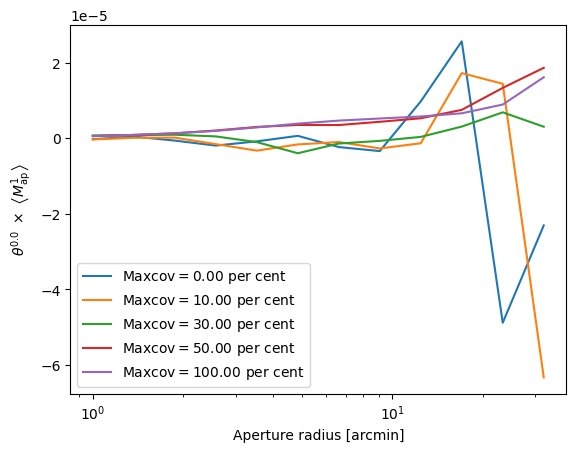

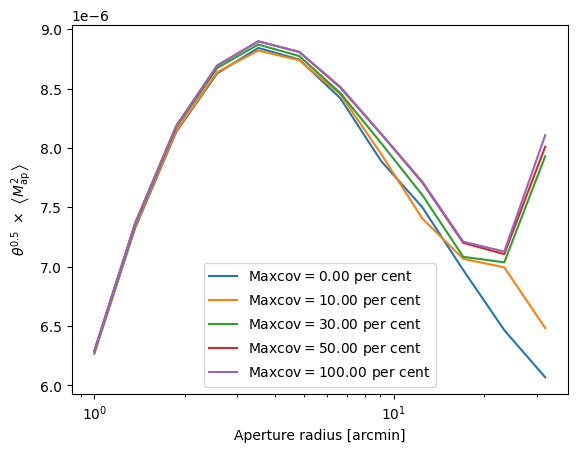

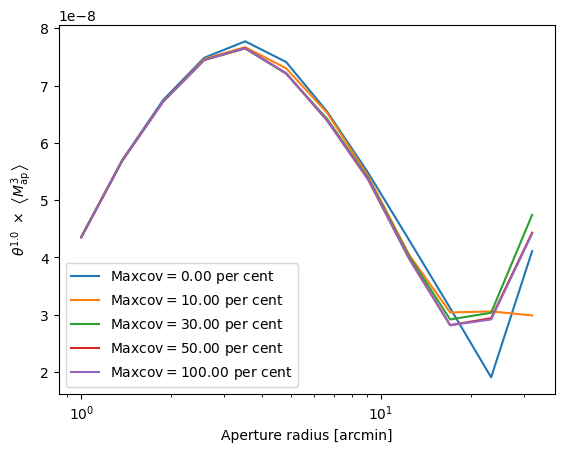

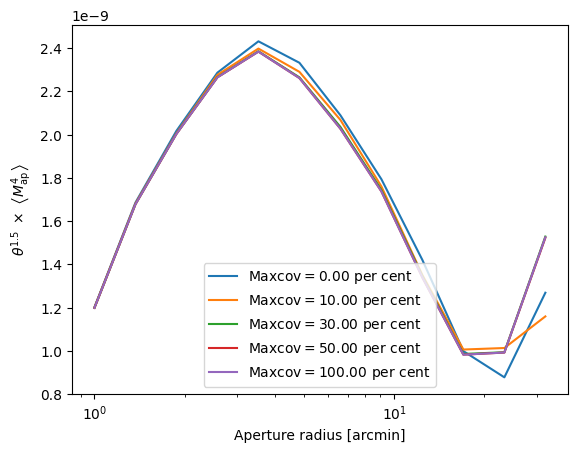

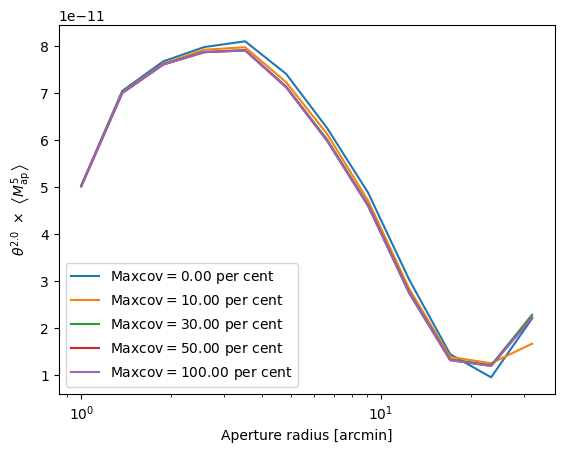

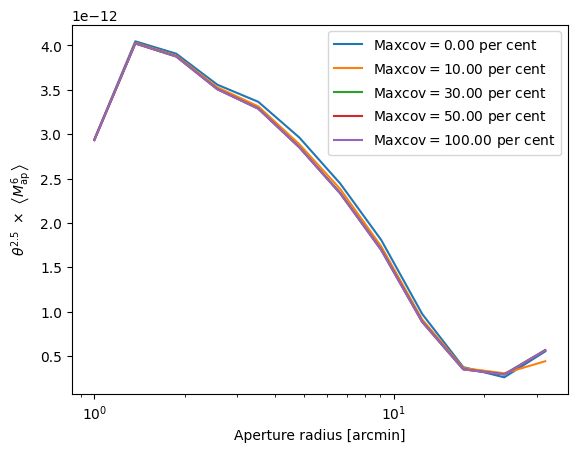

In [14]:
for order in range(direct.order_max):
    for covcut in range(direct.nfrac_covs):
        plt.semilogx(direct.radii, direct.radii**(.5*order)*mapn[:,covcut,order],label=r'$\rm{Max cov}=%.2f$ per cent'%(100*direct.frac_covs[covcut]))
        plt.xlabel('Aperture radius [arcmin]')
        plt.ylabel(r'$\theta^{%.1f} \ \times \ \left\langle M_{\rm ap}^%i\right\rangle$'%((0.5*order),order+1))
        plt.legend()
    plt.show()

<a id="Mapn_equal_tomo"></a>
## Computation of the equal-scale aperture mass statistics (tomographic)

Now let us repeat the same calculation with tomography

In [15]:
%%time
mapn, mapn_weights = direct.process(shapecat,dotomo=True)

Done 12/12 aperture radiiCPU times: user 17min 5s, sys: 916 ms, total: 17min 6s
Wall time: 29.3 s


Looking at the shape we see that the number of tomographic bin combinations quickly blows up.

In [16]:
mapn.shape

(12, 5, 83)

For being able to readily access a specific tomographic bin combination one can use the `genzcombi` method which gives the correct index for a tomographic bin combination $(z_1,\cdots,z_k)$. Note that we only allocate combinations with $z_i \leq z_{i+1}$.

In [17]:
direct.genzcombi([0,1,1,2])

26

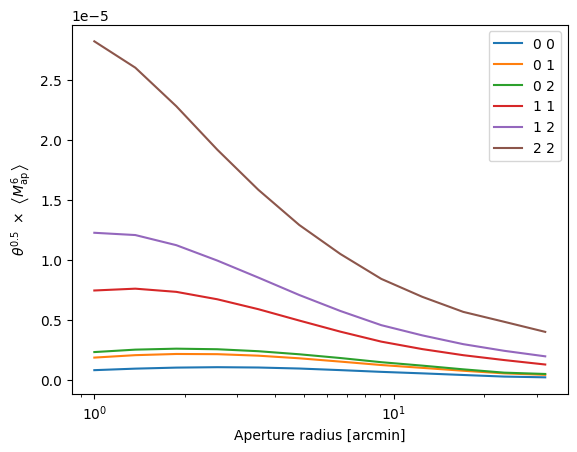

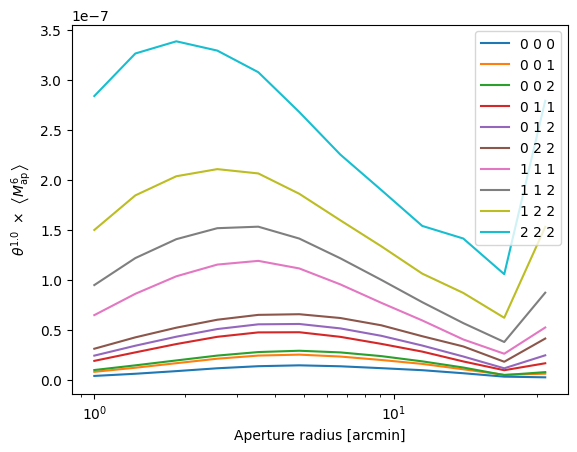

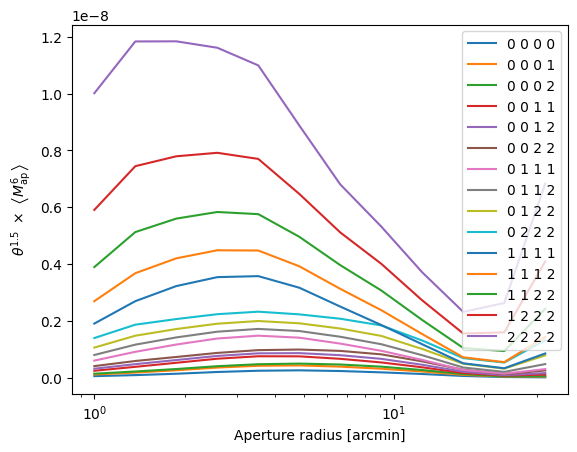

In [18]:
elcov = 0
# Order = 2
for z1 in range(shapecat.nbinsz):
    for z2 in range(z1,shapecat.nbinsz):
        zcombi = direct.genzcombi([z1,z2])
        plt.semilogx(direct.radii, mapn[:,elcov,direct.genzcombi([z1,z2])],label='%i %i'%(z1,z2))
plt.xlabel('Aperture radius [arcmin]')
plt.ylabel(r'$\theta^{%.1f} \ \times \ \left\langle M_{\rm ap}^%i\right\rangle$'%((0.5),order+1))
plt.legend()
plt.show()

# Order = 3
for z1 in range(shapecat.nbinsz):
    for z2 in range(z1,shapecat.nbinsz):
        for z3 in range(z2,shapecat.nbinsz):
            zcombi = direct.genzcombi([z1,z2,z3])
            plt.semilogx(direct.radii, direct.radii*mapn[:,elcov,direct.genzcombi([z1,z2,z3])],label='%i %i %i'%(z1,z2,z3))
plt.xlabel('Aperture radius [arcmin]')
plt.ylabel(r'$\theta^{%.1f} \ \times \ \left\langle M_{\rm ap}^%i\right\rangle$'%((1),order+1))
plt.legend()
plt.show()

# Order = 4
for z1 in range(shapecat.nbinsz):
    for z2 in range(z1,shapecat.nbinsz):
        for z3 in range(z2,shapecat.nbinsz):
            for z4 in range(z3,shapecat.nbinsz):
                _full = mapn[:,elcov,direct.genzcombi([z1,z2,z3,z4])]
                _disc = (mapn[:,elcov,direct.genzcombi([z1,z2])] * mapn[:,elcov,direct.genzcombi([z3,z4])] + 
                        mapn[:,elcov,direct.genzcombi([z1,z3])] * mapn[:,elcov,direct.genzcombi([z2,z4])] + 
                        mapn[:,elcov,direct.genzcombi([z1,z4])] * mapn[:,elcov,direct.genzcombi([z2,z3])])
                plt.semilogx(direct.radii, direct.radii**1.5*(_full-_disc),label='%i %i %i %i'%(z1,z2,z3,z4))
plt.xlabel('Aperture radius [arcmin]')
plt.ylabel(r'$\theta^{%.1f} \ \times \ \left\langle M_{\rm ap}^%i\right\rangle$'%((1.5),order+1))
plt.legend()
plt.show()

<a id="Mapn_maps"></a>
## Computing aperture mass maps


For a more visual inspection of the ingredients going into the computation of the direct estimator we also provide a method to compute the aperture mass map from a shape catalog.

In [19]:
# Index of aperture radius to consider
indR = 5
print(direct.radii[indR])

4.832357777617789


In [20]:
counts, covs, Msn, Sn, Mapn, Mapn_var = direct.getmap(indR, shapecat, dotomo=True)

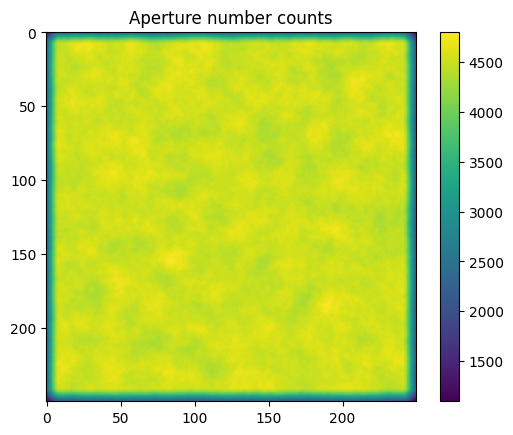

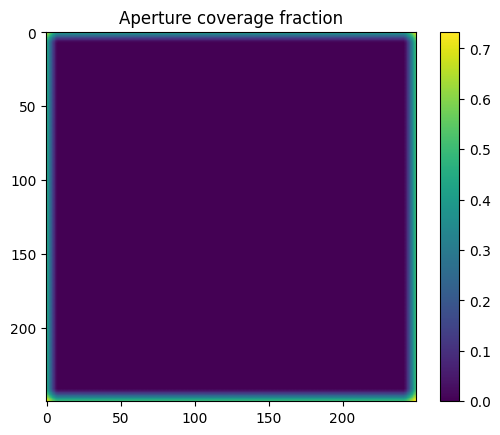

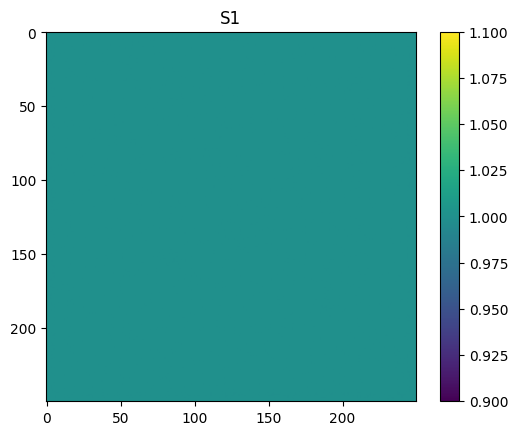

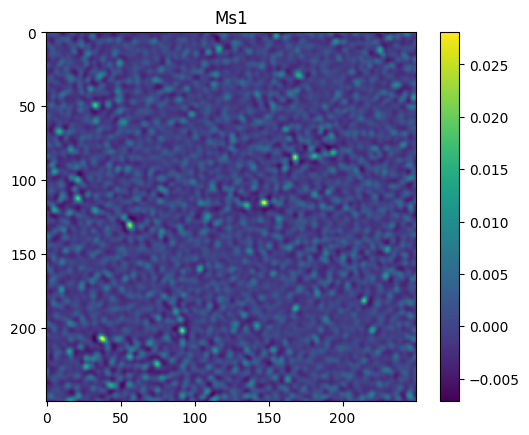

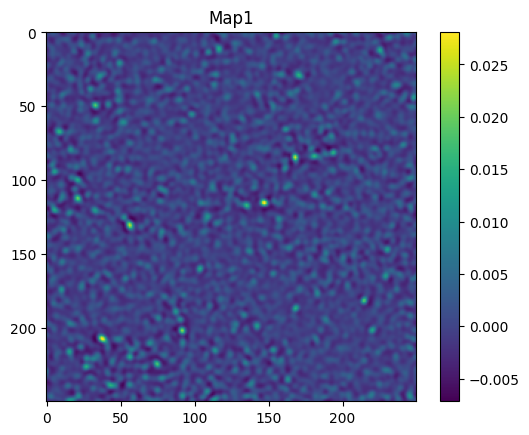

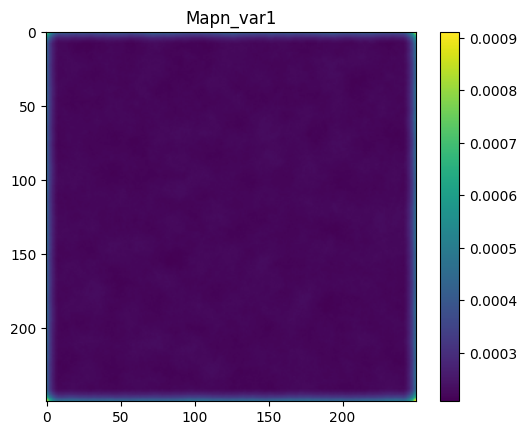

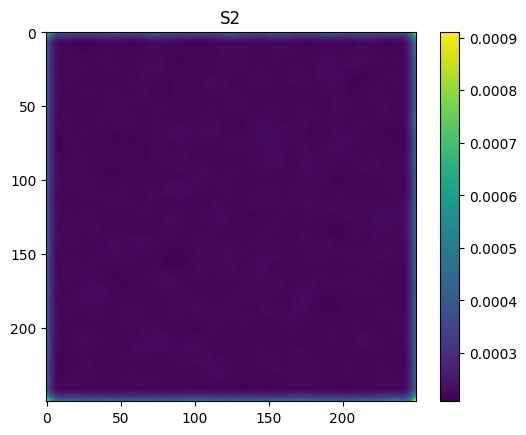

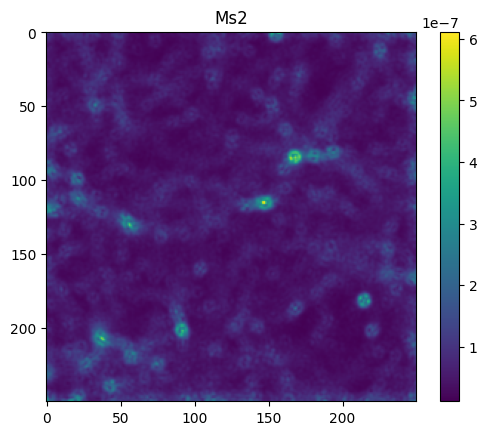

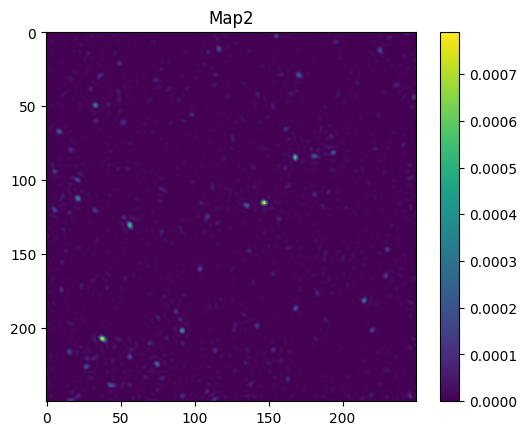

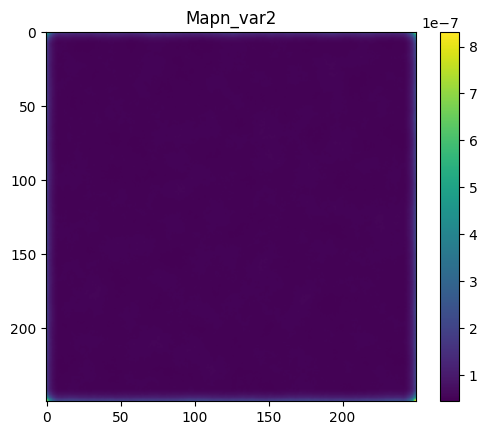

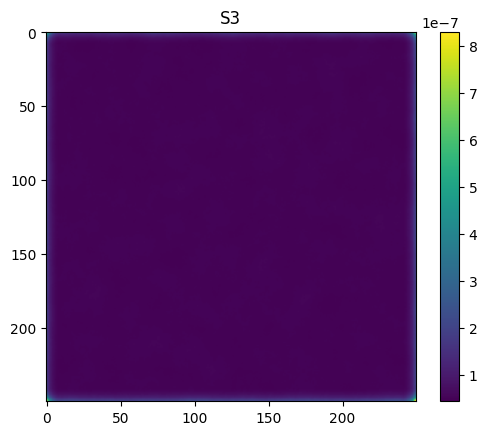

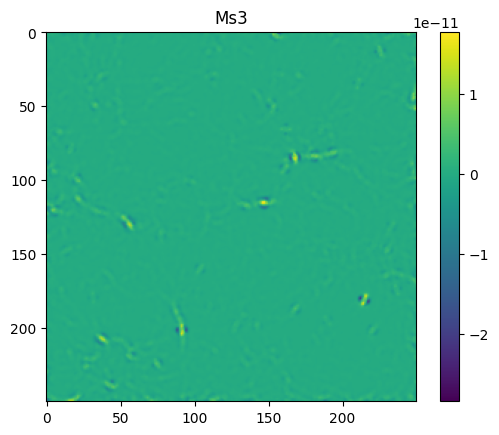

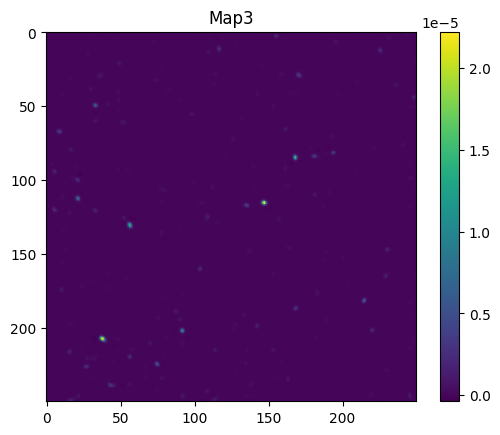

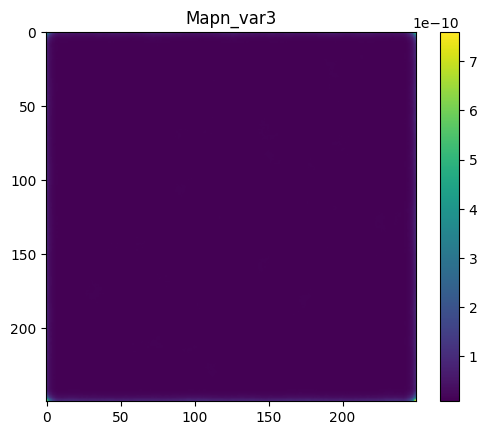

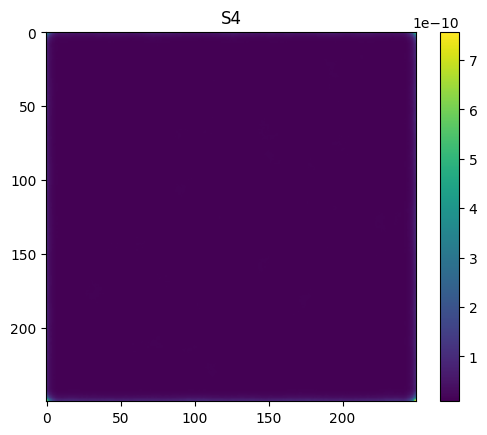

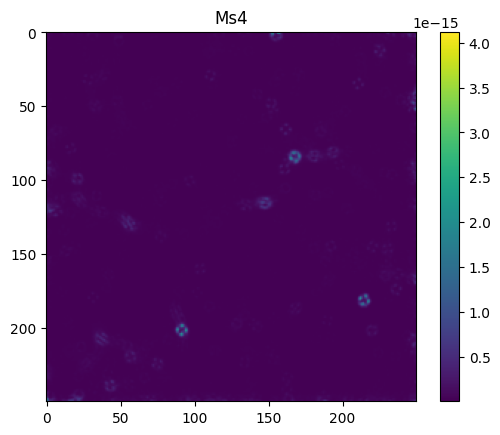

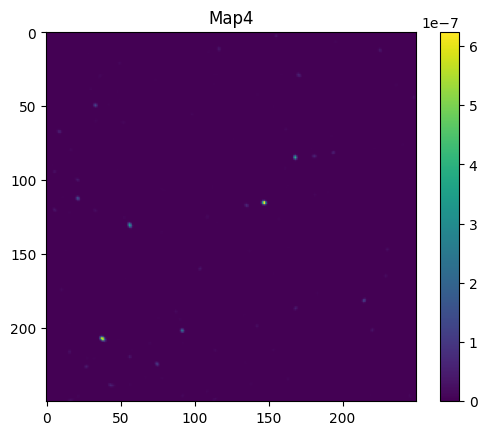

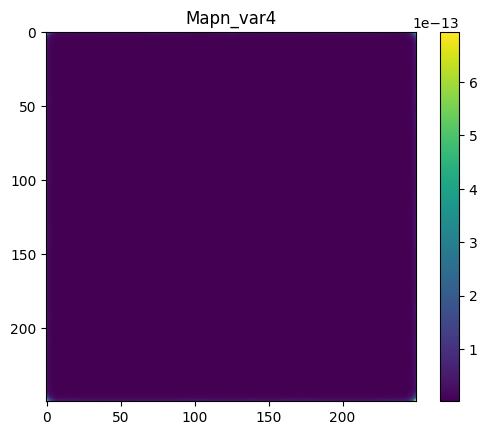

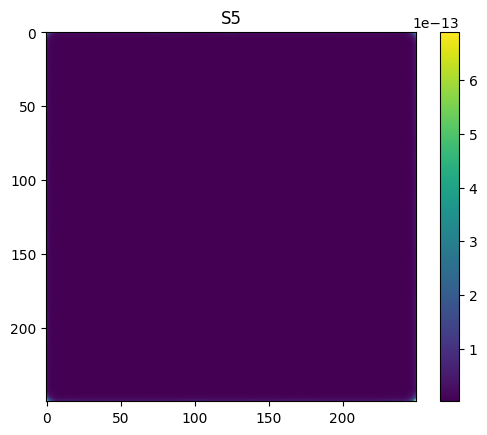

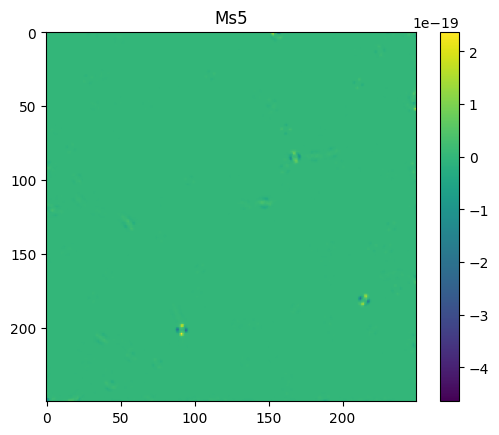

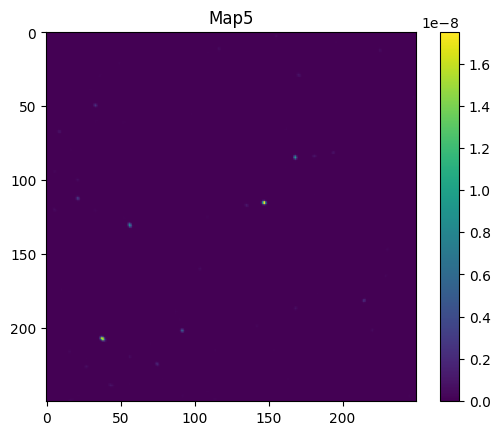

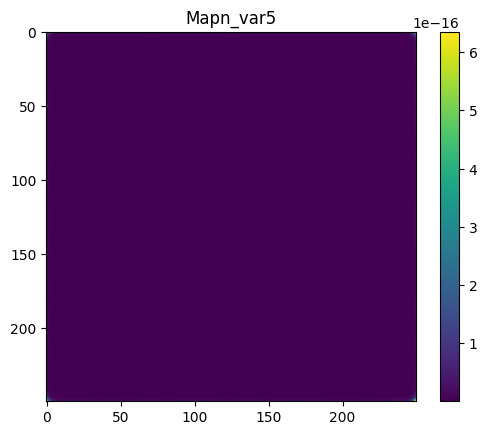

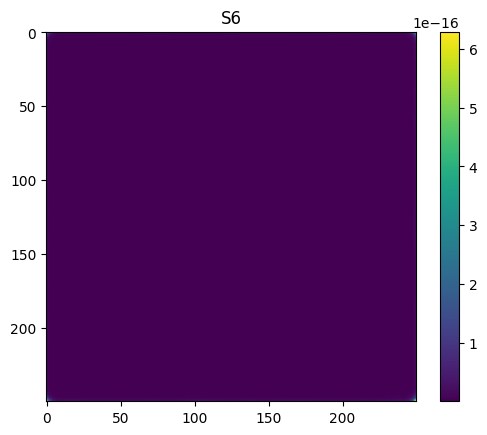

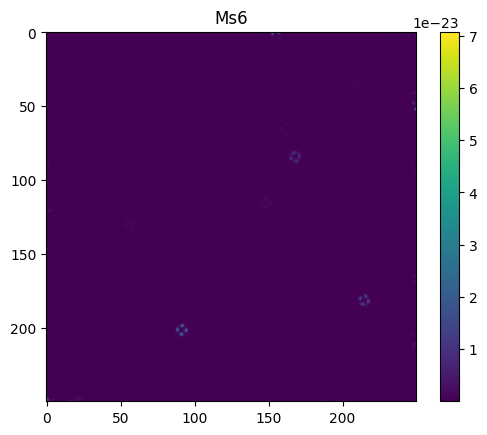

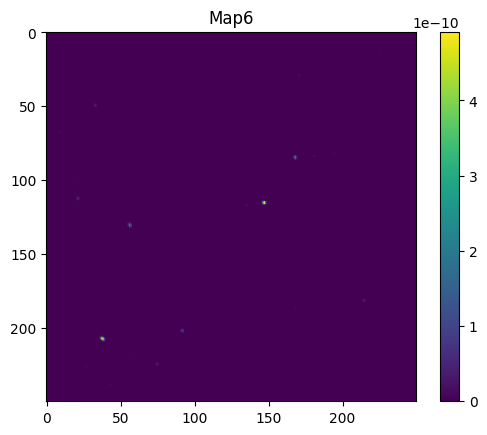

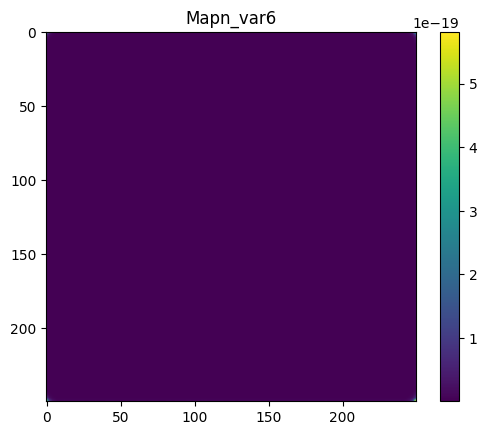

In [21]:
elbinz = 1
plt.imshow(counts[elbinz,0])
plt.colorbar()
plt.title('Aperture number counts')
plt.show()

plt.imshow(covs[0])
plt.colorbar()
plt.title('Aperture coverage fraction')
plt.show()

for order in range(direct.order_max):
    plt.imshow(Sn[elbinz,order])
    plt.colorbar()
    plt.title('S%i'%(order+1))
    plt.show()
    
    plt.imshow(Msn[elbinz,order])
    plt.colorbar()
    plt.title('Ms%i'%(order+1))
    plt.show()
    
    plt.imshow(Mapn[elbinz,order])
    plt.colorbar()
    plt.title('Map%i'%(order+1))
    plt.show()
    
    plt.imshow(np.abs(Mapn_var[elbinz,order]))
    plt.colorbar()
    plt.title('Mapn_var%i'%(order+1))
    plt.show()

In [22]:
1

1